In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,38302,None,None,85821.955263
2020-06-13,38303,None,None,79735.338835
2020-06-14,38304,None,None,74081.715681
2020-06-15,38305,None,None,68755.955727
2020-06-16,38306,None,None,64012.228277
...,...,...,...,...
2021-03-10,38573,None,None,110165.680662
2021-03-11,38574,None,None,106143.001824
2021-03-12,38575,None,None,101851.860280


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-14_2021-03-14-18-02.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-13_2021-03-13-16-31.pickle


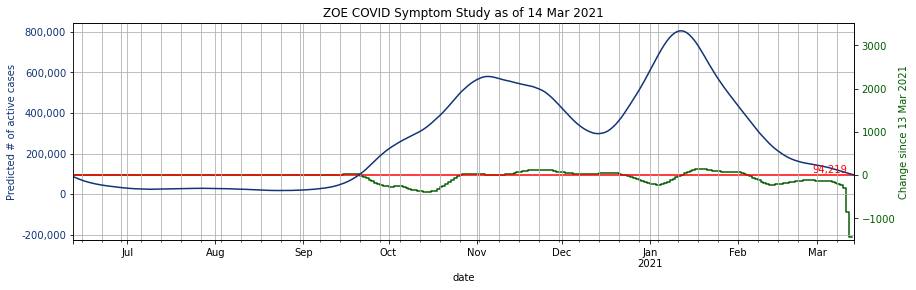

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

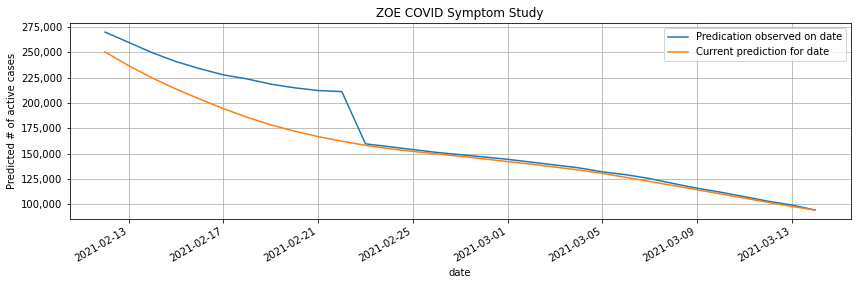

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-03-14_2021-03-14-18-03.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
280,Doncaster,E08000017,1.059173
194,Staffordshire Moorlands,E07000198,0.779244
161,East Lindsey,E07000137,0.732542
25,Leicester,E06000016,0.700910
372,Moray,S12000020,0.687161
311,South Ayrshire,S12000028,0.684797
268,Oldham,E08000004,0.658141
112,Eastbourne,E07000061,0.627396
249,Wakefield,E08000036,0.508321
234,Manchester,E08000003,0.491077
